To fix importing issues

In [1]:
!pip show scikit-learn #Location kısmındaki konumu aşağıdaki append fonksiyonunun içine yapıştıryoruz

Name: scikit-learn
Version: 1.2.0
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /Users/boramert/opt/anaconda3/lib/python3.9/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: imbalanced-learn, pyod, scikit-learn-intelex


In [2]:
import sys
sys.path.append('/Users/boramert/opt/anaconda3/lib/python3.9/site-packages') #Konum buraya yapıştırılacak

Import packages

In [3]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers, Sequential

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
from matplotlib import gridspec

from scipy import stats

import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
pd.set_option("display.max_rows", None,
             "display.max_columns", None)

/Users/boramert/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def scaling(ds): 
    scaler=preprocessing.StandardScaler()
    scaled_ds=scaler.fit_transform(ds)
    return scaled_ds

def drop_infs(ds):
    ds.replace([np.inf, -np.inf], np.nan, inplace=True)
    ds.dropna(how='any', inplace=True)
    return ds

Get dataset

In [5]:
dataset=pd.read_csv("test_dataset.csv")
dataset.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
dataset=drop_infs(dataset)

labels = dataset[' Label'].copy()

le = preprocessing.LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = pd.DataFrame(labels_encoded, columns=[' Label'])
labels_encoded = labels_encoded[' Label'].copy()

In [7]:
labels.unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

In [8]:
labels.value_counts()

BENIGN                        1741839
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name:  Label, dtype: int64

In [9]:
labels_encoded.unique()

array([ 0,  2, 10,  1,  9, 12, 14, 13,  7, 11,  6,  5,  4,  3,  8])

In [10]:
dataset.loc[dataset[' Label'] == 'BENIGN', ' Label'] = 0 #Saldırılar için 1 normaller için 0 değeri verme
dataset.loc[dataset[' Label'] != 0, ' Label'] = 1

In [11]:
#Dataseti x ve y olarak ayırma
y=dataset[' Label']
x=dataset.drop(' Label', axis=1)
x_scaled=scaling(x)

In [12]:
#Dataseti normal ve anormal olarak ayırma
x_normal = x_scaled[y == 0]
x_anomaly = x_scaled[y == 1]
anomaly_labels = labels_encoded[labels_encoded!=0]

Set autoencoder & data

In [13]:
x_normal_train = np.asarray(x_normal).astype(np.float32)

x_normal_train = tf.cast(x_normal_train, tf.float32)

2022-12-15 18:26:32.141898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
from tensorflow.keras.optimizers import Adam
autoencoder = Sequential()
autoencoder.add(Dense(32,  activation='relu', input_shape=(78,)))
autoencoder.add(Dense(16,  activation='relu'))
autoencoder.add(Dense(8,    activation='linear', name="Compressed"))
autoencoder.add(Dense(16,  activation='relu'))
autoencoder.add(Dense(32,  activation='relu'))
autoencoder.add(Dense(78,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')

In [15]:
history = autoencoder.fit(x_normal_train, 
                          x_normal_train, 
                          batch_size=64,     
                          epochs=10, 
                          verbose=1, 
                          validation_split = 0.20)

Epoch 1/10
21773/21773 [==============================] - 18s 794us/step - loss: 0.7548 - val_loss: 0.3538
Epoch 2/10
21773/21773 [==============================] - 17s 778us/step - loss: 0.7488 - val_loss: 0.3534
Epoch 3/10
21773/21773 [==============================] - 17s 786us/step - loss: 0.7481 - val_loss: 0.3533
Epoch 4/10
21773/21773 [==============================] - 17s 777us/step - loss: 0.7478 - val_loss: 0.3530
Epoch 5/10
21773/21773 [==============================] - 17s 778us/step - loss: 0.7477 - val_loss: 0.3528
Epoch 6/10
21773/21773 [==============================] - 17s 780us/step - loss: 0.7475 - val_loss: 0.3527
Epoch 7/10
21773/21773 [==============================] - 17s 778us/step - loss: 0.7472 - val_loss: 0.3527
Epoch 8/10
21773/21773 [==============================] - 18s 818us/step - loss: 0.7471 - val_loss: 0.3526
Epoch 9/10
21773/21773 [==============================] - 17s 792us/step - loss: 0.7471 - val_loss: 0.3528
Epoch 10/10
21773/21773 [============

In [16]:
encoder = Model(autoencoder.input, autoencoder.get_layer('Compressed').output)

In [17]:
encoded_normal = encoder.predict(x_normal)   #Normal verilerin feature değerleri
encoded_anomaly = encoder.predict(x_anomaly) #Saldırı verilerinin feature değerleri

17393/17393 [==============================] - 6s 333us/step


In [18]:
encoded_x = np.append(encoded_normal, encoded_anomaly, axis = 0) #Normal ve saldırı feature değerleri birleştirme
normal_y = np.zeros(encoded_normal.shape[0])     #Normal verilerin label'ları
anomaly_y = np.ones(encoded_anomaly.shape[0])    #Saldırı verilerinin label'ları
encoded_y = np.append(normal_y, anomaly_y)       #Label birleştirme 0-1
encoded_labels = np.append(normal_y, anomaly_labels)  #Label birleştirme 0-14

In [19]:
np.unique(encoded_labels, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14.]),
 array([1741839,    1956,  128025,   10293,  230124,    5499,    5796,
           7935,      11,      36,  158804,    5897,    1507,      21,
            652]))

In [20]:
y_xgb = np.c_[encoded_y, encoded_labels] #1. sütun: 0-1 sınıflandırma, 2. sütun: 0-14 sınıflandırma

In [21]:
y_xgb

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [1., 3.],
       [1., 3.],
       [1., 3.]])

In [22]:
x_train, x_test, y_train, y_test = train_test_split(encoded_x, y_xgb, 
                                                    test_size=0.20, 
                                                    random_state=12345,
                                                    stratify=y_xgb)

In [23]:
y_train_labels = y_train[:,1]  # Train verisinin y labelları
y_test_labels = y_test[:,1]    # Test verisinin y labelları

In [24]:
np.unique(y_train_labels, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14.]),
 array([1393471,    1565,  102420,    8234,  184099,    4399,    4637,
           6348,       9,      29,  127043,    4718,    1205,      17,
            522]))

In [25]:
c = le.inverse_transform(y_test_labels.astype(int))
np.unique(c, return_counts=True)

(array(['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk',
        'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed',
        'Infiltration', 'PortScan', 'SSH-Patator',
        'Web Attack � Brute Force', 'Web Attack � Sql Injection',
        'Web Attack � XSS'], dtype=object),
 array([348368,    391,  25605,   2059,  46025,   1100,   1159,   1587,
             2,      7,  31761,   1179,    302,      4,    130]))

In [26]:
# !pip install imblearn

In [27]:
#from imblearn.over_sampling import SMOTE

In [28]:
#strategy = {0:1393471, 1:1565, 2:102420, 3:9000, 4:184099, 5:5000, 6:4637, 7:6348, 8:9, 9:29, 10:127043, 11:4718,
#           12:2000, 13:50, 14:522}

In [29]:
#oversample = SMOTE(sampling_strategy=strategy)

In [30]:
#x_train, y_train_labels = oversample.fit_resample(x_train, y_train_labels)

In [31]:
#np.unique(y_train_labels, return_counts=True)

In [32]:
#yy = []
#for i in range(len(y_train_labels)):
#    if y_train_labels[i] == 0:
#        yy.append(0)
#    else:
#        yy.append(1)
#y_train_yeni = np.array(yy) #oversample hali
#y_train_yeni = np.c_[y_train_yeni.astype(int), y_train_labels]

In [33]:
#np.unique(y_train_yeni, return_counts=True)

XGBoost

In [34]:
!pip install xgboost

In [35]:
from sklearn.linear_model import RidgeCV, ElasticNet, LassoCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix 

In [36]:
model_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=1, learning_rate=0.2, verbosity=1)

cv = RepeatedStratifiedKFold(n_splits=5, random_state=12345)
n_scores = cross_val_score(model_xgb, x_train, y_train[:,0], scoring='accuracy', cv=cv, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.922 (0.005)


In [37]:
model_xgb.fit(x_train, y_train[:,0])
xgb_preds = model_xgb.predict(x_test)

In [38]:
model_xgb.score(x_test, y_test[:,0])

0.9242797691432499

First training

In [39]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test[:,0], xgb_preds))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test[:,0], xgb_preds))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95    348368
         1.0       0.91      0.77      0.83    111311

    accuracy                           0.92    459679
   macro avg       0.92      0.87      0.89    459679
weighted avg       0.92      0.92      0.92    459679


Accuracy Score:  0.9242797691432499


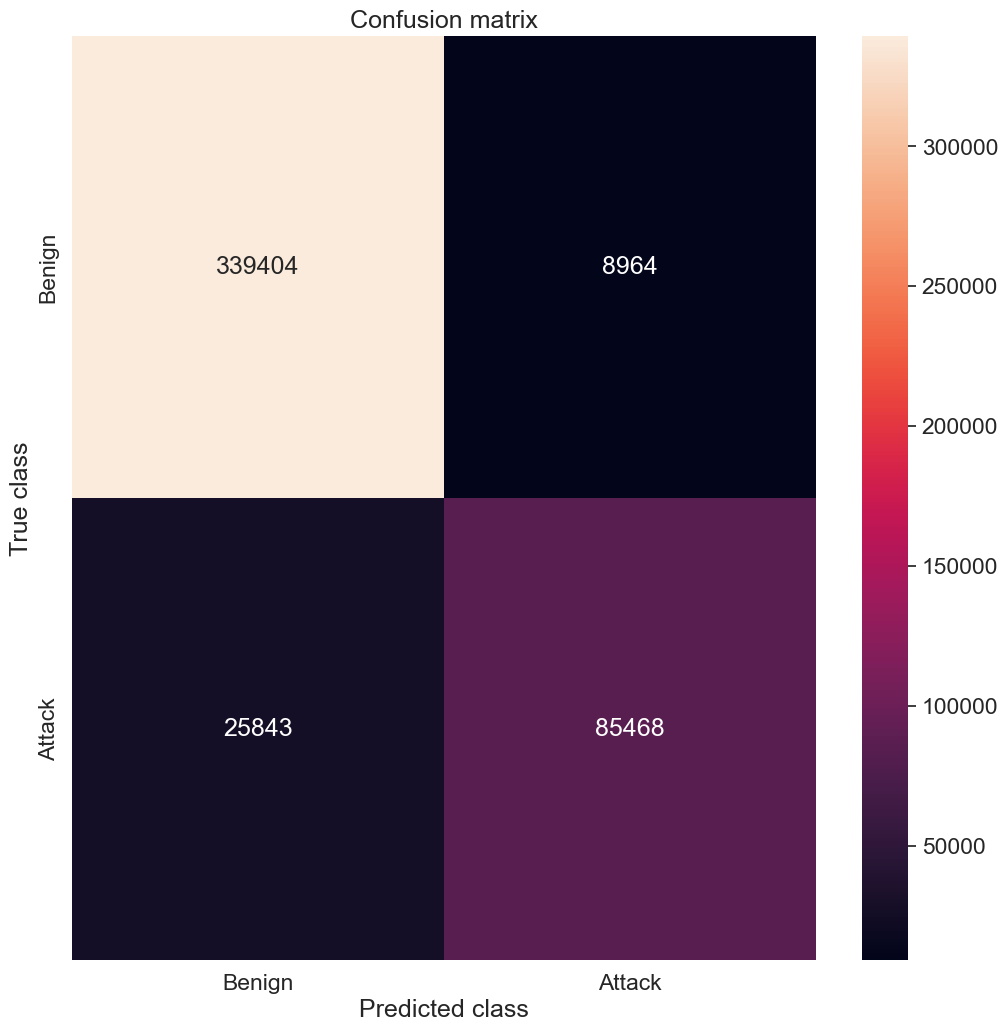

In [40]:
LABELS = ['Benign', 'Attack'] 
conf_matrix = confusion_matrix(y_test[:,0], xgb_preds) 
plt.figure(figsize =(12, 12)) 
sns.heatmap(conf_matrix, xticklabels = LABELS,  
            yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('True class')
plt.xlabel('Predicted class') 
plt.show()

In [41]:
xgb_preds.shape

(459679,)

In [42]:
y_test_labels.shape

(459679,)

Predict Attack Types

In [43]:
anomaly_pred_x = []
anomaly_pred_labels = []
predi = [] # doğru mu yanlış mı bildik kontrol
for i in range(len(xgb_preds)):
    if (xgb_preds[i]==y_test[i,0]) and (xgb_preds[i]==1):
        anomaly_pred_x.append(x_test[i,:])
        anomaly_pred_labels.append(y_test_labels[i])
    if xgb_preds[i]==y_test[i,0]:
        predi.append(1)
    else:
        predi.append(0)
y_test = np.c_[y_test, predi] #1. sütun: 0-1 sınıflandırma, 2. sütun: 0-14 sınıflandırma, 3. sütun: predict doğruluğu
pred_anomaly_x = np.array(anomaly_pred_x) #Test verisinde doğru bilinen anomalilerin x'leri
pred_anomaly_y = np.array(anomaly_pred_labels)  #Test verisinde doğru bilinen anomalilerin y'leri

In [44]:
y_test

array([[0., 0., 1.],
       [1., 2., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 1.]])

In [45]:
benign_toplam=0
bot_toplam=0
ddos_toplam=0
dos_goldenEye_toplam=0
dos_hulk_toplam=0
dos_slowhttptest_toplam=0
dos_slowloris_toplam=0
ftp_patator_toplam=0
heartbleed_toplam=0
infiltration_toplam=0
portScan_toplam=0
ssh_patator_toplam=0
brute_force_toplam=0
sql_injection_toplam=0
xss_toplam=0

for i in range(len(y_test)):
    statement=y_test[i,1]
    if statement==0:
        benign_toplam+=1
    elif statement==1:
        bot_toplam+=1
    elif statement==2:
        ddos_toplam+=1
    elif statement==3:
        dos_goldenEye_toplam+=1
    elif statement==4:
        dos_hulk_toplam+=1
    elif statement==5:
        dos_slowhttptest_toplam+=1
    elif statement==6:
        dos_slowloris_toplam+=1
    elif statement==7:
        ftp_patator_toplam+=1
    elif statement==8:
        heartbleed_toplam+=1
    elif statement==9:
        infiltration_toplam+=1
    elif statement==10:
        portScan_toplam+=1
    elif statement==11:
        ssh_patator_toplam+=1
    elif statement==12:
        brute_force_toplam+=1
    elif statement==13:
        sql_injection_toplam+=1
    elif statement==14:
        xss_toplam+=1

In [46]:
# Bu labela sahip kaç tane verinin anomali olup olmadığı doğru bilindiği sayısı tutuluyor
benign=0
bot=0
ddos=0
dos_goldenEye=0
dos_hulk=0
dos_slowhttptest=0
dos_slowloris=0
ftp_patator=0
heartbleed=0
infiltration=0
portScan=0
ssh_patator=0
brute_force=0
sql_injection=0
xss=0

for i in range(len(y_test)):
    if y_test[i,2]==1:
        statement=y_test[i,1]
        if statement==0:
            benign+=1
        elif statement==1:
            bot+=1
        elif statement==2:
            ddos+=1
        elif statement==3:
            dos_goldenEye+=1
        elif statement==4:
            dos_hulk+=1
        elif statement==5:
            dos_slowhttptest+=1
        elif statement==6:
            dos_slowloris+=1
        elif statement==7:
            ftp_patator+=1
        elif statement==8:
            heartbleed+=1
        elif statement==9:
            infiltration+=1
        elif statement==10:
            portScan+=1
        elif statement==11:
            ssh_patator+=1
        elif statement==12:
            brute_force+=1
        elif statement==13:
            sql_injection+=1
        elif statement==14:
            xss+=1

In [47]:
print("Benign : ",(benign/benign_toplam)*100)
print("Bot : ",(bot/bot_toplam)*100)
print("DDos : ",(ddos/ddos_toplam)*100)
print("Dos GoldenEye : ",(dos_goldenEye/dos_goldenEye_toplam)*100)
print("Dos Hulk : ",(dos_hulk/dos_hulk_toplam)*100)
print("Dos Slow HTTP Test : ",(dos_slowhttptest/dos_slowhttptest_toplam)*100)
print("Dos SlowLoris : ",(dos_slowloris/dos_slowloris_toplam)*100)
print("FTP Patator : ",(ftp_patator/ftp_patator_toplam)*100)
print("Heartbleed : ",(heartbleed/heartbleed_toplam)*100)
print("Infiltration : ",(infiltration/infiltration_toplam)*100)
print("PortScan : ",(portScan/portScan_toplam)*100)
print("SSH Patator : ",(ssh_patator/ssh_patator_toplam)*100)
print("Brute Force : ",(brute_force/brute_force_toplam)*100)
print("SQL Injection : ",(sql_injection/sql_injection_toplam)*100)
print("XSS : ",(xss/xss_toplam)*100)


Benign :  97.42685895375006
Bot :  1.7902813299232736
DDos :  73.40363210310487
Dos GoldenEye :  45.31325886352599
Dos Hulk :  87.18522542096686
Dos Slow HTTP Test :  17.0
Dos SlowLoris :  1.8981880931837791
FTP Patator :  0.2520478890989288
Heartbleed :  100.0
Infiltration :  0.0
PortScan :  79.9250653316961
SSH Patator :  0.4240882103477523
Brute Force :  0.0
SQL Injection :  0.0
XSS :  0.7692307692307693


In [48]:
pred_anomaly_y = pred_anomaly_y.astype(int)

In [49]:
np.unique(pred_anomaly_y, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 14]),
 array([    7, 18795,   933, 40127,   187,    22,     4,     2, 25385,
            5,     1]))

In [50]:
a = le.inverse_transform(pred_anomaly_y)
np.unique(a, return_counts=True)

(array(['Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest',
        'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'PortScan',
        'SSH-Patator', 'Web Attack � XSS'], dtype=object),
 array([    7, 18795,   933, 40127,   187,    22,     4,     2, 25385,
            5,     1]))

In [51]:
le2 = preprocessing.LabelEncoder() #Saldırılar 0'dan başlasın diye tekrar label encoder
pred_anomaly_y = le2.fit_transform(a)

In [52]:
np.unique(pred_anomaly_y, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([    7, 18795,   933, 40127,   187,    22,     4,     2, 25385,
            5,     1]))

In [53]:
z = le2.inverse_transform(pred_anomaly_y)
np.unique(z, return_counts=True)

(array(['Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest',
        'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'PortScan',
        'SSH-Patator', 'Web Attack � XSS'], dtype=object),
 array([    7, 18795,   933, 40127,   187,    22,     4,     2, 25385,
            5,     1]))

In [54]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(pred_anomaly_x, pred_anomaly_y, 
                                                    test_size=0.20, 
                                                    random_state=12345)

In [55]:
attack_predictor = xgb.XGBClassifier(n_estimators=100, max_depth=1, learning_rate=0.2, verbosity=1)

cv = RepeatedStratifiedKFold(n_splits=5, random_state=12345)
n_scores = cross_val_score(attack_predictor, x_train2, y_train2, scoring='accuracy', cv=cv, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

/Users/boramert/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/boramert/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/boramert/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/boramert/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/boramert/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, whi

Accuracy: 0.979 (0.001)


In [56]:
attack_predictor.fit(x_train2, y_train2)
attack_preds = attack_predictor.predict(x_test2)

In [57]:
attack_predictor.score(x_test2, y_test2)

0.9785304785304785

In [58]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test2, attack_preds))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test2, attack_preds))


Classification Report: 
              precision    recall  f1-score   support

           1       0.93      0.98      0.95      3763
           2       0.98      0.97      0.98       187
           3       0.99      0.97      0.98      7976
           4       1.00      1.00      1.00        36
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           8       1.00      1.00      1.00      5126
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1

    accuracy                           0.98     17094
   macro avg       0.77      0.77      0.77     17094
weighted avg       0.98      0.98      0.98     17094


Accuracy Score:  0.9785304785304785


/Users/boramert/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/boramert/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/boramert/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


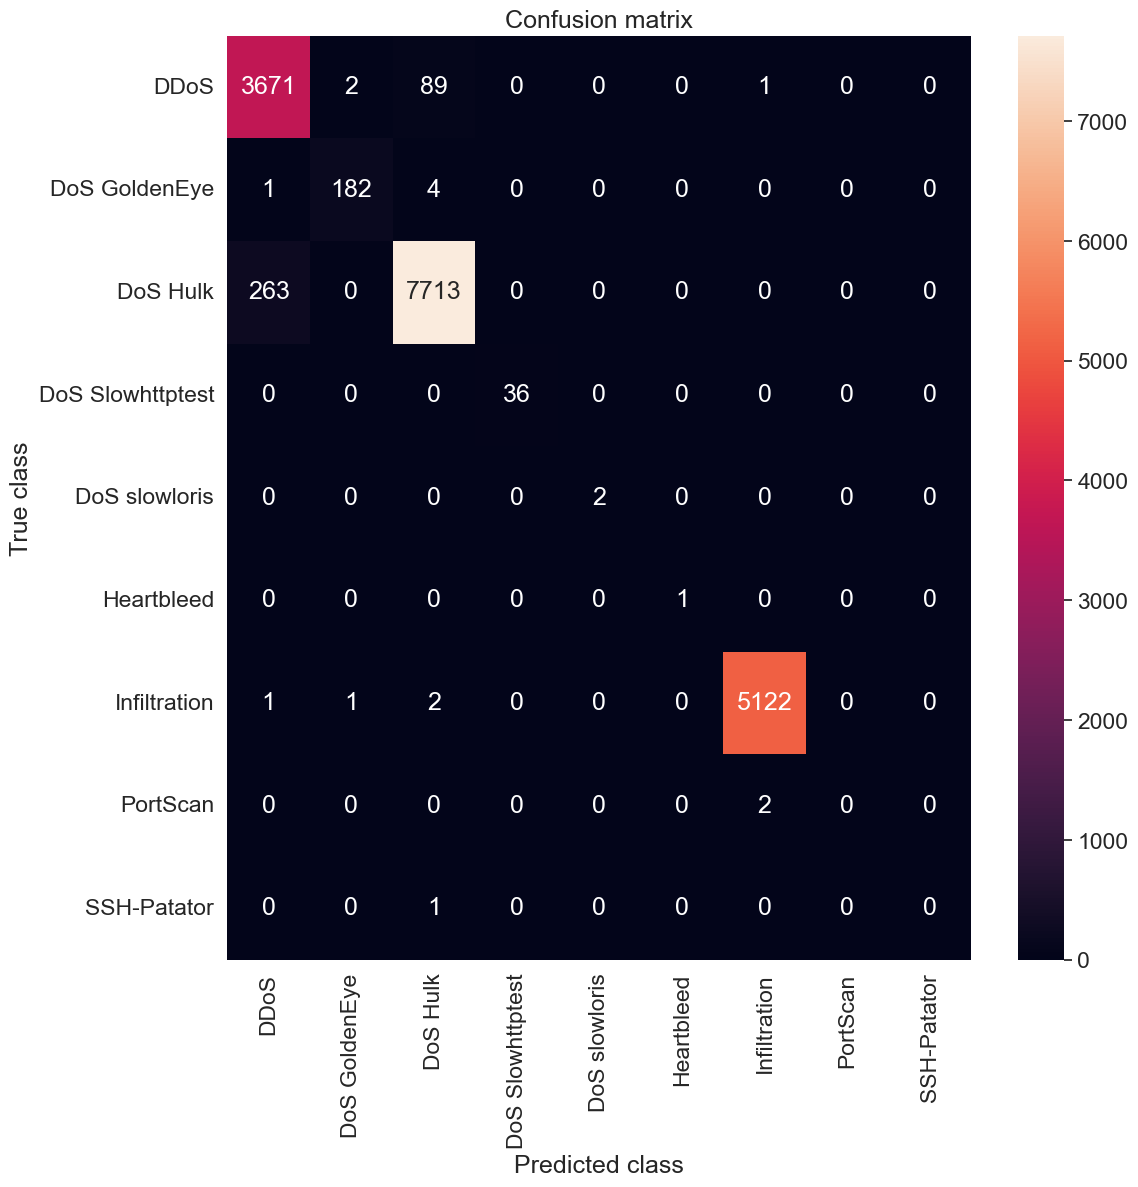

In [59]:
LABELS = ['DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest',
        'DoS slowloris', 'Heartbleed', 'Infiltration', 'PortScan',
        'SSH-Patator']
conf_matrix = confusion_matrix(y_test2, attack_preds) 
plt.figure(figsize =(12, 12)) 
sns.heatmap(conf_matrix, xticklabels = LABELS,  
            yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('True class')
plt.xlabel('Predicted class') 
plt.show()